In [1]:
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
# create a data generator
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
batch_size = 128
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('C:/Users/Usuario/Desktop/UNED/mineria_datos/Practica3_Aprendizajeprofundo/anuka1200/train/', class_mode='binary', batch_size=batch_size, shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
# load and iterate validation dataset
val_it = datagen.flow_from_directory('C:/Users/Usuario/Desktop/UNED/mineria_datos/Practica3_Aprendizajeprofundo/anuka1200/validation/', class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDTH))
# load and iterate test dataset
test_it = datagen.flow_from_directory('C:/Users/Usuario/Desktop/UNED/mineria_datos/Practica3_Aprendizajeprofundo/anuka1200/test/', class_mode='binary', batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [5]:
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(128, 150, 150, 3), min=0.000, max=0.980


In [6]:
# visualize images from batches
sample_training_images, _ = next(train_it)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

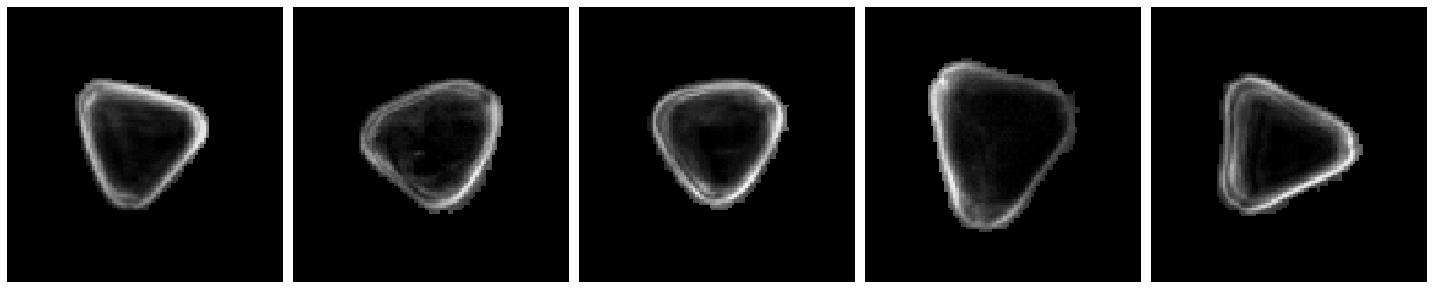

In [7]:
plotImages(sample_training_images[:5])

# Define model 1

In [8]:
# Create neural network architecture
# This is a neural network without a hidden layer
# equivalent to a logistic binomial regression
modelnet_1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    keras.layers.Dense(2, activation='softmax')
])


# Compile the model
modelnet_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 135002    
Total params: 135,002
Trainable params: 135,002
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit the model
total_train=1800
total_val=200
history_1 = modelnet_1.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size
)

Epoch 1/30
14/14 [==============================] - 20s 1s/step - loss: 0.5509 - accuracy: 0.7584 - val_loss: 0.5020 - val_accuracy: 0.8438
Epoch 2/30
14/14 [==============================] - 2s 173ms/step - loss: 0.3782 - accuracy: 0.8475 - val_loss: 0.3705 - val_accuracy: 0.8906
Epoch 3/30
14/14 [==============================] - 1s 97ms/step - loss: 0.3199 - accuracy: 0.8708 - val_loss: 0.3110 - val_accuracy: 0.8906
Epoch 4/30
14/14 [==============================] - 2s 123ms/step - loss: 0.3266 - accuracy: 0.8738 - val_loss: 0.2911 - val_accuracy: 0.9062
Epoch 5/30
14/14 [==============================] - 2s 114ms/step - loss: 0.3306 - accuracy: 0.8600 - val_loss: 0.3862 - val_accuracy: 0.8594
Epoch 6/30
14/14 [==============================] - 2s 115ms/step - loss: 0.3149 - accuracy: 0.8780 - val_loss: 0.5158 - val_accuracy: 0.8125
Epoch 7/30
14/14 [==============================] - 2s 116ms/step - loss: 0.4443 - accuracy: 0.8272 - val_loss: 0.2476 - val_accuracy: 0.9062
Epoch 8/3

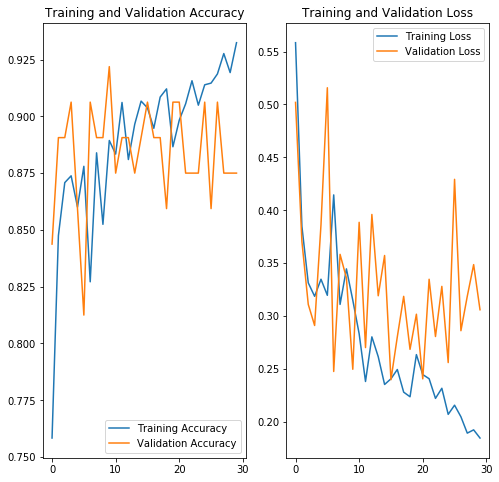

In [10]:
# Visualize training results
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [11]:
test_loss, test_acc = modelnet_1.evaluate(test_it, verbose=2)

print('\nTest accuracy:', test_acc)


7/7 - 3s - loss: 0.3880 - accuracy: 0.8400

Test accuracy: 0.84


# Define model 2

In [12]:
# define model
# Create neural network architecture 
modelnet_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Dense(512, activation='relu'),
    Dense(128, activation='sigmoid'),
    Dense(2, activation='softmax')

])

# Compile the model
modelnet_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               34560512  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 34,626,434
Trainable params: 34,626,434
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fit model
total_train=1800
total_val=200
history_2 = modelnet_2.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size
)

Epoch 1/30
14/14 [==============================] - 15s 1s/step - loss: 0.6132 - accuracy: 0.7210 - val_loss: 0.3249 - val_accuracy: 0.8281
Epoch 2/30
14/14 [==============================] - 10s 703ms/step - loss: 0.3448 - accuracy: 0.8389 - val_loss: 0.2953 - val_accuracy: 0.8750
Epoch 3/30
14/14 [==============================] - 5s 337ms/step - loss: 0.2946 - accuracy: 0.8800 - val_loss: 0.2715 - val_accuracy: 0.9062
Epoch 4/30
14/14 [==============================] - 4s 306ms/step - loss: 0.2727 - accuracy: 0.8898 - val_loss: 0.2988 - val_accuracy: 0.8750
Epoch 5/30
14/14 [==============================] - 4s 305ms/step - loss: 0.2585 - accuracy: 0.9061 - val_loss: 0.2639 - val_accuracy: 0.9062
Epoch 6/30
14/14 [==============================] - 4s 294ms/step - loss: 0.2211 - accuracy: 0.9181 - val_loss: 0.2168 - val_accuracy: 0.9375
Epoch 7/30
14/14 [==============================] - 4s 291ms/step - loss: 0.1973 - accuracy: 0.9276 - val_loss: 0.2844 - val_accuracy: 0.9219
Epoch 8

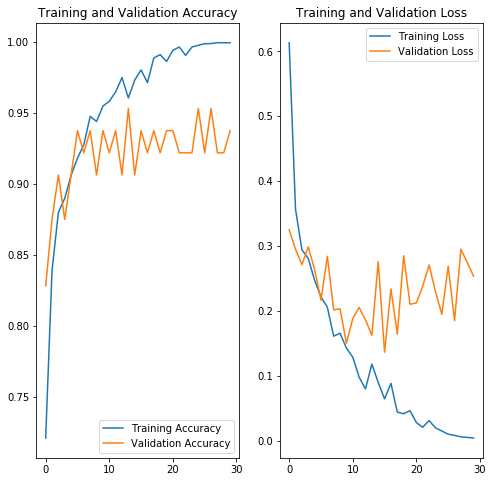

In [14]:
# Visualize training results
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [15]:
# Accuracy
test_loss, test_acc = modelnet_2.evaluate(test_it, verbose=2)

print('\nTest accuracy:', test_acc)


# Evaluate model
loss = modelnet_2.evaluate_generator(test_it, steps=24)
loss

7/7 - 3s - loss: 0.3719 - accuracy: 0.9075

Test accuracy: 0.9075


[0.367873211701711, 0.90804595]

# Define 3 model

In [16]:
# Create neural network architecture
modelnet_3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

modelnet_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 82944)            

In [17]:
total_train=1800
total_val=200
history_3 = modelnet_3.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size
)


Epoch 1/30
14/14 [==============================] - 37s 3s/step - loss: 0.5293 - accuracy: 0.7787 - val_loss: 0.3651 - val_accuracy: 0.8438
Epoch 2/30
14/14 [==============================] - 37s 3s/step - loss: 0.3474 - accuracy: 0.8415 - val_loss: 0.3232 - val_accuracy: 0.8750
Epoch 3/30
14/14 [==============================] - 37s 3s/step - loss: 0.2859 - accuracy: 0.8714 - val_loss: 0.3053 - val_accuracy: 0.8750
Epoch 4/30
14/14 [==============================] - 34s 2s/step - loss: 0.2744 - accuracy: 0.8822 - val_loss: 0.2635 - val_accuracy: 0.8906
Epoch 5/30
14/14 [==============================] - 35s 2s/step - loss: 0.2646 - accuracy: 0.9067 - val_loss: 0.2262 - val_accuracy: 0.9062
Epoch 6/30
14/14 [==============================] - 34s 2s/step - loss: 0.2106 - accuracy: 0.9187 - val_loss: 0.2265 - val_accuracy: 0.8906
Epoch 7/30
14/14 [==============================] - 34s 2s/step - loss: 0.1917 - accuracy: 0.9246 - val_loss: 0.2342 - val_accuracy: 0.9062
Epoch 8/30
14/14 [==

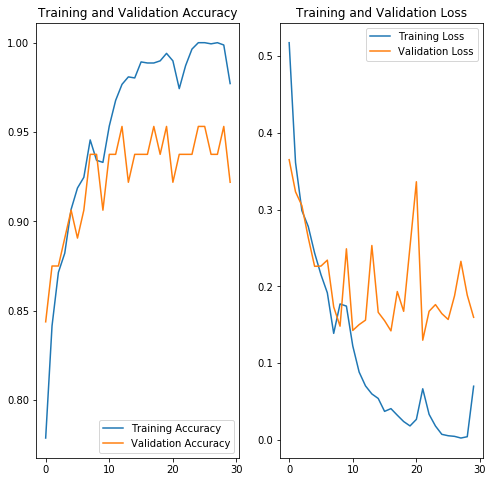

In [18]:
# Visualize training results
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [19]:
test_loss, test_acc = modelnet_3.evaluate(test_it, verbose=5)

print('\nTest accuracy:', test_acc)



Test accuracy: 0.945


# Graph all models


In [20]:
# Visualize training results
acc_1 = history_1.history['accuracy']
acc_2 = history_2.history['accuracy']
acc_3 = history_3.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
val_acc_2 = history_2.history['val_accuracy']
val_acc_3 = history_3.history['val_accuracy']

Text(0.5, 1.0, 'Training Accuracy')

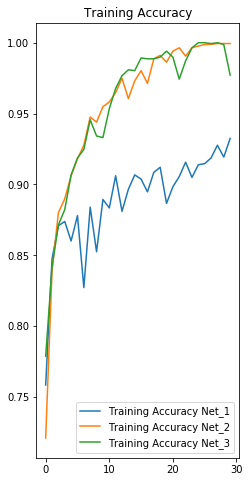

In [21]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy Net_1')
plt.plot(epochs_range, acc_2, label='Training Accuracy Net_2')
plt.plot(epochs_range, acc_3, label='Training Accuracy Net_3')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

Text(0.5, 1.0, 'Validation Accuracy')

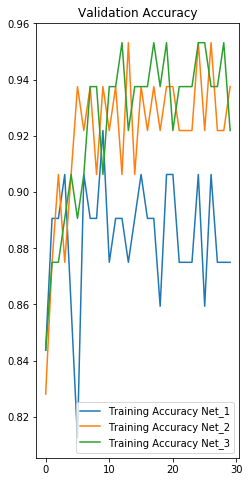

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_acc_1, label='Training Accuracy Net_1')
plt.plot(epochs_range, val_acc_2, label='Training Accuracy Net_2')
plt.plot(epochs_range, val_acc_3, label='Training Accuracy Net_3')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

# Loss

In [23]:
loss_1 = history_1.history['loss']
loss_2 = history_2.history['loss']
loss_3 = history_3.history['loss']
val_loss_1 = history_1.history['val_loss']
val_loss_2 = history_2.history['val_loss']
val_loss_3 = history_3.history['val_loss']

Text(0.5, 1.0, 'Training Accuracy')

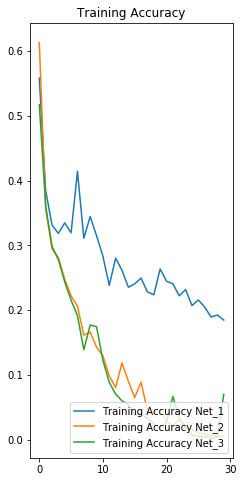

In [24]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_1, label='Training Accuracy Net_1')
plt.plot(epochs_range, loss_2, label='Training Accuracy Net_2')
plt.plot(epochs_range, loss_3, label='Training Accuracy Net_3')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

Text(0.5, 1.0, 'Validation Accuracy')

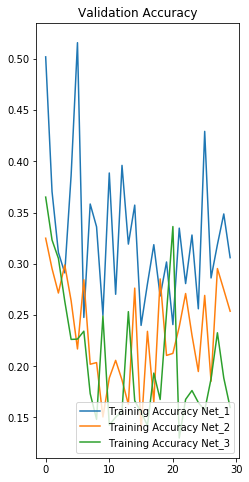

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_loss_1, label='Training Accuracy Net_1')
plt.plot(epochs_range, val_loss_2, label='Training Accuracy Net_2')
plt.plot(epochs_range, val_loss_3, label='Training Accuracy Net_3')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')